# Local Volatility Model vs. Black-Scholes Using Real Nvidia Market Data

intro/description

In [1]:
# imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import multiprocessing
from sklearn import metrics
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from scipy.interpolate import RegularGridInterpolator
from joblib import Parallel, delayed

In [2]:
# get NVDA options data for past 5 years
ticker = yf.Ticker("NVDA")
options_list = []
exps = ticker.options  # expiration dates

for e in exps:
    opt = ticker.option_chain(e)
    opt_df = pd.concat([opt.calls, opt.puts])
    opt_df["expirationDate"] = pd.to_datetime(e)
    options_list.append(opt_df)

# combine all options into one DataFrame
options = pd.concat(options_list, ignore_index=True)

# days until expiration
today = datetime.datetime.today()
options["dte"] = (options["expirationDate"] - today).dt.days / 365
options['T'] = options['dte'] / 365 # years until expiration (T)

# call/put labels
options["option_type"] = options["contractSymbol"].apply(
    lambda x: "Call" if "C" in x else "Put"
)
call = options[options['option_type'] == 'Call']
put = options[options['option_type'] == 'Put']

# display
options

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expirationDate,dte,T,option_type
0,NVDA250131C00050000,2025-01-30 19:14:47+00:00,50.0,71.27,71.00,71.70,-1.930000,-2.636613,25.0,309.0,0.000010,True,REGULAR,USD,2025-01-31,0.000000,0.000000,Call
1,NVDA250131C00055000,2025-01-29 16:38:54+00:00,55.0,67.72,66.00,66.70,0.000000,0.000000,80.0,96.0,0.000010,True,REGULAR,USD,2025-01-31,0.000000,0.000000,Call
2,NVDA250131C00060000,2025-01-29 15:26:13+00:00,60.0,64.30,60.75,61.45,0.000000,0.000000,10.0,100.0,0.000010,True,REGULAR,USD,2025-01-31,0.000000,0.000000,Call
3,NVDA250131C00065000,2025-01-30 14:42:51+00:00,65.0,55.15,56.00,56.70,-7.049999,-11.334404,1.0,52.0,0.000010,True,REGULAR,USD,2025-01-31,0.000000,0.000000,Call
4,NVDA250131C00070000,2025-01-30 15:29:08+00:00,70.0,48.50,50.80,51.50,-4.250000,-8.056872,4.0,86.0,0.000010,True,REGULAR,USD,2025-01-31,0.000000,0.000000,Call
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7534,NVDA270115P00260000,2025-01-27 14:36:09+00:00,260.0,135.06,139.60,140.55,0.000000,0.000000,2.0,187.0,0.356452,True,REGULAR,USD,2027-01-15,1.956164,0.005359,Put
7535,NVDA270115P00270000,2025-01-17 17:44:04+00:00,270.0,133.97,148.90,150.10,0.000000,0.000000,2.0,59.0,0.353034,True,REGULAR,USD,2027-01-15,1.956164,0.005359,Put
7536,NVDA270115P00280000,2025-01-23 17:05:08+00:00,280.0,136.50,158.65,159.95,0.000000,0.000000,30.0,60.0,0.358832,True,REGULAR,USD,2027-01-15,1.956164,0.005359,Put
7537,NVDA270115P00290000,2025-01-29 18:37:36+00:00,290.0,168.83,168.55,169.45,0.000000,0.000000,2.0,117.0,0.348029,True,REGULAR,USD,2027-01-15,1.956164,0.005359,Put


## Implied Volatility Surface

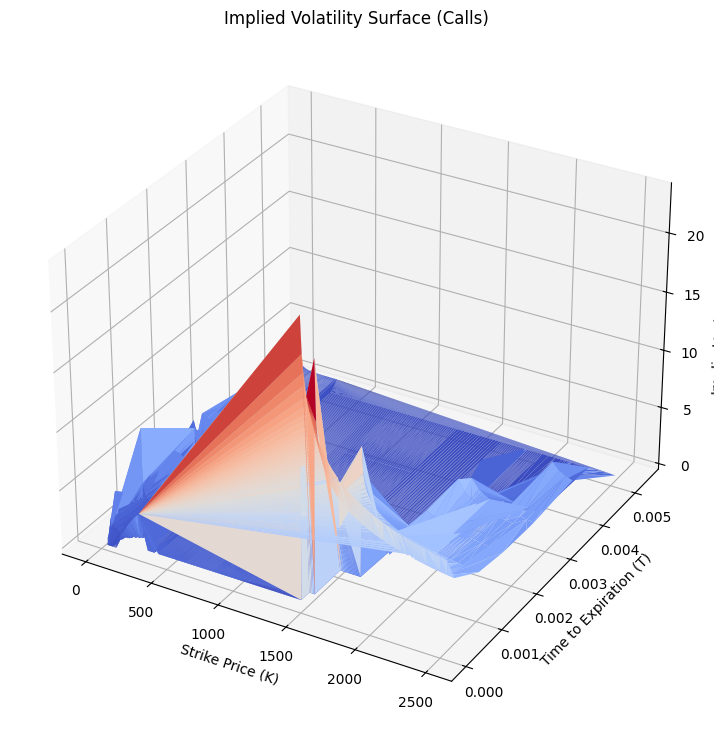

In [3]:
# calls
K, T, iv = call['strike'],  call['T'], call['impliedVolatility']
fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')
surf = ax.plot_trisurf(K, T, iv, cmap='coolwarm',
                       linewidth=0.1, antialiased=True)

# labels and title
ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Time to Expiration (T)')
ax.set_zlabel('Implied Volatility (IV)')
ax.set_title('Implied Volatility Surface (Calls)')

plt.show()

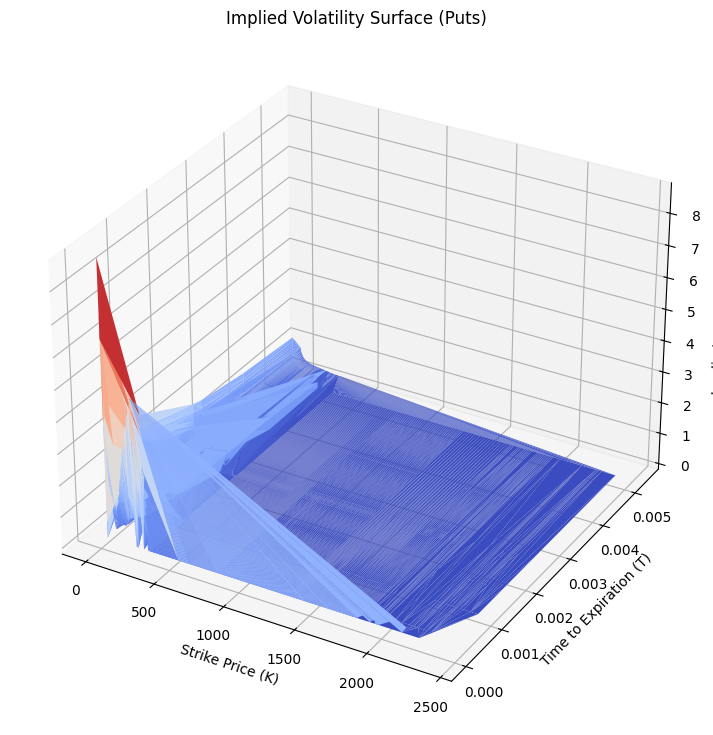

In [4]:
# puts
K, T, iv = put['strike'],  put['T'], put['impliedVolatility']
fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')
surf = ax.plot_trisurf(K, T, iv, cmap='coolwarm',
                       linewidth=0.1, antialiased=True)

# labels and title
ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Time to Expiration (T)')
ax.set_zlabel('Implied Volatility (IV)')
ax.set_title('Implied Volatility Surface (Puts)')

plt.show()

## Local Volatility Surface

add Dupire’s equation in LaTex

In [5]:
# Initialize C using Black-Scholes
def black_scholes(S, K, T, r, sigma, type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    if type == 'put':
        return - S * norm.cdf(-d1) + K * np.exp(-r * T) * norm.cdf(-d2)

# Parameters
steps = 100
S0 = 100     # Spot price
K_min, K_max = 50, 150  # Strike price range
T_min, T_max = 0.01, 2  # Time to maturity range (2 years)
r = 0.05    # Risk-free rate
sigma = 0.2 # Volatility
dT = (K_max - K_min) / steps
dK = (T_max - T_min) / steps

In [6]:
# Solve For Partial Derivatives Using Finite Difference Method
def fd_solve_diff(K_min, K_max, T_min, T_max, r, S0, steps, dT, dK):
    # construct domain grid
    num_K = steps
    num_T = steps
    K_vals = np.linspace(K_min, K_max, num_K)
    T_vals = np.linspace(T_min, T_max, num_K)

    # initialize C
    C = np.zeros((num_K, num_T))
    for i, K in enumerate(K_vals):
        for j, T in enumerate(T_vals):
            C[i, j] = black_scholes(S0, K, T, r, sigma)

    # Solve for dC/dK
    dC_dK = np.zeros_like(C)
    for i in range(1, num_K - 1):
        for j in range(num_T):
            dC_dK[i, j] = (C[i+1, j] - C[i-1, j]) / (2 * dK) 

    # Solve for dC/dt
    dC_dT = np.zeros_like(C)
    for i in range(num_K):
         for j in range(1, num_T - 1):
            dC_dT[i, j] = (C[i, j+1] - C[i, j-1]) / (2 * dT)

    # Solve for d2C_dK2 (2nd Derivative)
    dC_dK2 = np.zeros_like(C)
    for i in range(1, num_K - 1):
         for j in range(num_T):
            dC_dK2[i, j] = (C[i+1, j] - 2 * C[i, j] - C[i-1, j]) / (2 * dT)

    return C, K_vals, T_vals, dC_dK, dC_dT, dC_dK2

In [7]:
C, K_vals, T_vals, dC_dK, dC_dT, dC_dK2 = fd_solve_diff(K_min, K_max, T_min, T_max, r, S0, steps, dT, dK)

In [8]:
# Input Values into Dupire’s equation
sigma_local = np.zeros_like(C)
for i, K in enumerate(K_vals):  
    for j, T in enumerate(T_vals):
        denom = 0.5 * (K**2) * dC_dK2[i, j]
        if abs(denom) < 1e-10:
            sigma_local[i, j] = np.nan  # set to 0
            continue

        num = dC_dT[i, j] + r * K * dC_dK[i, j]
        sigma_local[i, j] = np.sqrt(max(num / denom, 0))

/Users/ansa/opt/anaconda3/lib/python3.10/site-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


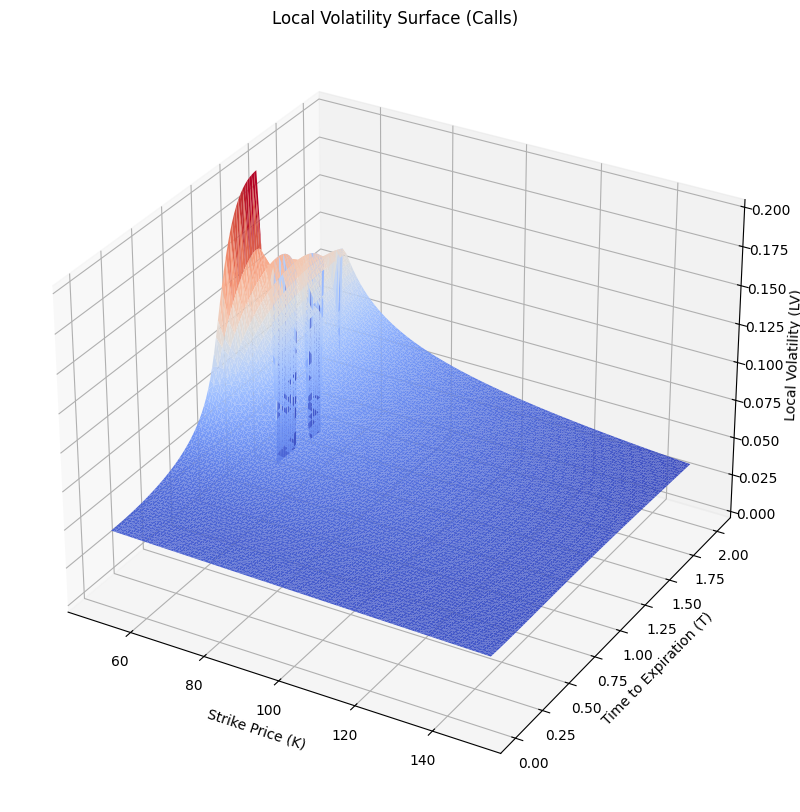

In [9]:
# plot results
K_vals_mesh, T_vals_mesh = np.meshgrid(K_vals, T_vals)

fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection='3d')



surf = ax.plot_trisurf(K_vals_mesh.ravel(), T_vals_mesh.ravel(), sigma_local.ravel(), cmap='coolwarm',
                       linewidth=0.1, antialiased=True)

# labels and title
ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Time to Expiration (T)')
ax.set_zlabel('Local Volatility (LV)')
ax.set_title('Local Volatility Surface (Calls)')

plt.show()

### 

## Monte Carlo Simulations: Local Volatility Vs. Black-Scholes

### Local Volatility

In [10]:
# Parameters
num_sims = 1000000  # number of simulations
steps = 100       # number of steps in each simulation
S0 = 100          # spot price
r = 0.05          # interest rate
K = 100           # strike price
T = 1             # time until expiration
dt = T / steps    # time step size 

interp_sigma = RegularGridInterpolator((K_vals, T_vals), sigma_local, bounds_error=False, fill_value=0)

# Monte Carlo simulation
def mc_sim(steps, S0, r, K, T, dt, num_chunk_sims):
    np.random.seed()
    S = np.zeros((num_chunk_sims, steps + 1))
    S[:, 0] = S0
    
    for t in range(1, steps + 1):
        K_interp = np.clip(S[:, t-1], K_vals.min(), K_vals.max())
        T_remaining = T - (t-1)*dt
        
        # interpolate sigma
        sigma = interp_sigma(np.vstack((K_interp, np.full_like(K_interp, T_remaining))).T)
        # replace nans with mean
        sigma = np.nan_to_num(sigma, nan=np.mean(sigma[~np.isnan(sigma)]))

        # Euler-Maruyama step
        Z = np.random.randn(num_chunk_sims)
        drift = (r - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt) * Z
        S[:, t] = S[:, t-1] * np.exp(drift + diffusion)
    
    return S

In [11]:
%%time
# parallelize the simulations
num_cores = multiprocessing.cpu_count()
chunk_size = num_sims // num_cores
S_list = Parallel(n_jobs=num_cores)(
    delayed(mc_sim)(steps, S0, r, K, T, dt, chunk_size) 
    for _ in range(num_cores)
)
S_array = np.concatenate(S_list, axis=0)

# Compute payoff
payoff = np.maximum(S_array[:, -1] - K, 0)
call_price = np.exp(-r * T) * np.mean(payoff)
print(f"Simulated Call Price: {call_price:.4f}")

Simulated Call Price: 5.7775
CPU times: user 328 ms, sys: 3.39 s, total: 3.72 s
Wall time: 9.89 s


### Black-Scholes